# Задание 1

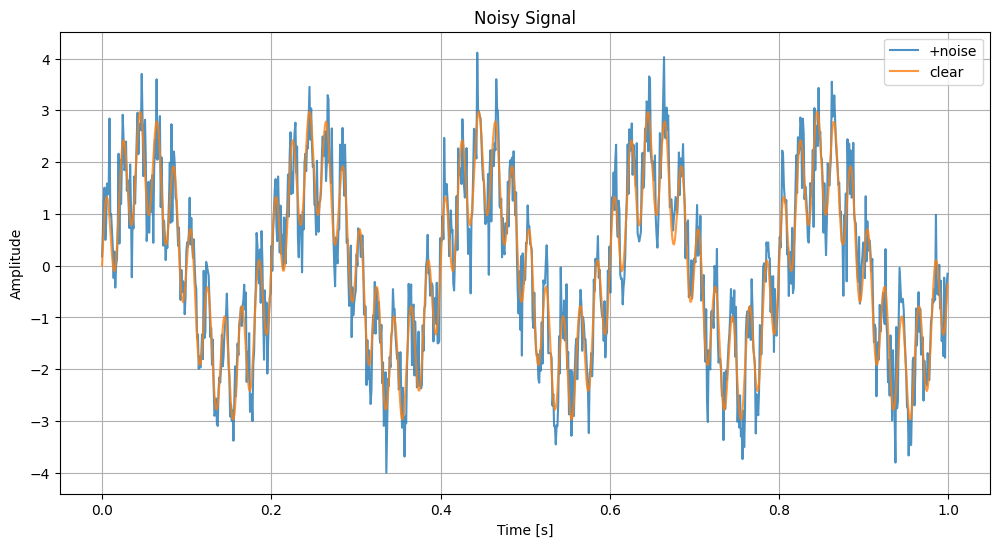

In [174]:
import numpy as np
import matplotlib.pyplot as plt

def gen_data(pN, freq, amp, noise_amp):
    # Generate the clean signal
    fs = 2**int(pow_N)  # Sampling frequency
    t = np.arange(0, 1.0, 1/fs)  # Time vector
    signal = sum(a * np.sin(2 * np.pi * f * t) for a, f in zip(amplitude, freq))
    # Add noise to the signal
    return t, signal, signal + noise_amp * np.random.normal(size=t.shape)

# Parameters
pow_N = 10 #power of frequency (will be ceiled)
frequencies = [5, 50]  # Frequencies of the sine waves
amplitude = [2, 1]  # Amplitude of the sine waves
noise_amplitude = 0.5  # Amplitude of the noise

t, signal, noisy_signal = gen_data(pow_N, frequencies, amplitude, noise_amplitude)

# Plot the noisy signal
plt.figure(figsize=(12, 6))
plt.plot(t, noisy_signal, alpha=0.8, label='+noise')
plt.plot(t, signal, alpha=0.8, label='clear')
plt.title('Noisy Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()


In [175]:
def fft(x):
    N = len(x)
    if N <= 1:
        return np.array([x])
    even = fft(x[0::2])
    odd = fft(x[1::2])
    N2 = min(len(even), len(odd))
    T = [np.exp(-2j * np.pi * k / N) * odd[k] for k in range(N2)]
    return np.array([even[k] + T[k] for k in range(N2)] + [even[k] - T[k] for k in range(N2)])

def ifft(X):
    N = len(X)
    # Prepare an array for the output
    res = np.zeros(N, dtype=complex)
    
    for n in range(N):
        # Compute the inverse FFT formula
        for k in range(N):
            res[n] += X[k] * np.exp(2j * np.pi * k * n / N)
        res[n] /= N  # Normalize by dividing by N
    
    return res


def algorithm(x, mag_threshold):
    # Perform FFT
    
    fft_signal = fft(noisy_signal[:np.power(2, int(np.log2(len(noisy_signal))))])
    frequencies = np.fft.fftfreq(len(fft_signal), d=1/len(fft_signal))

    # Plot the FFT result
    plt.figure(figsize=(12, 6))
    plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_signal)[:len(frequencies)//2])
    plt.title('FFT of Noisy Signal')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.show()

    # Create a band-pass filter mask
    filter_mask = np.abs(fft_signal) > mag_threshold
    # Apply the filter mask to the FFT result
    filtered_fft_signal = np.zeros_like(fft_signal)
    noise_fft_signal = fft_signal.copy()
    filtered_fft_signal[filter_mask] = fft_signal[filter_mask]
    noise_fft_signal[filter_mask] = 0

    # Plot the filtered FFT result
    plt.figure(figsize=(12, 6))
    plt.plot(frequencies[:len(frequencies)//2], np.abs(filtered_fft_signal)[:len(frequencies)//2])
    plt.title('Filtered FFT Signal')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.show()

    # Perform inverse FFT to get the denoised signal
    denoised_signal = ifft(filtered_fft_signal).real
    noise_signal = ifft(noise_fft_signal).real

    return denoised_signal.real, noise_signal

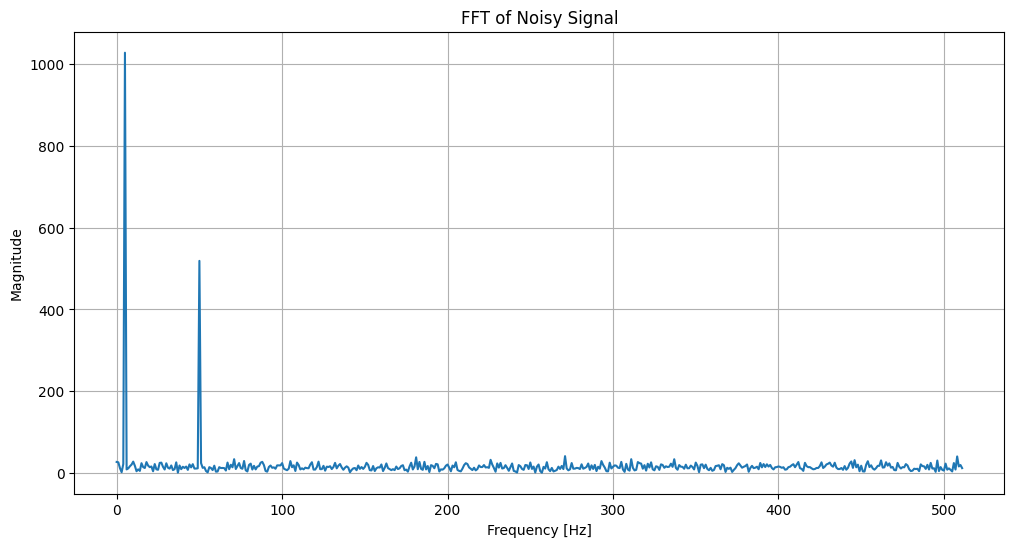

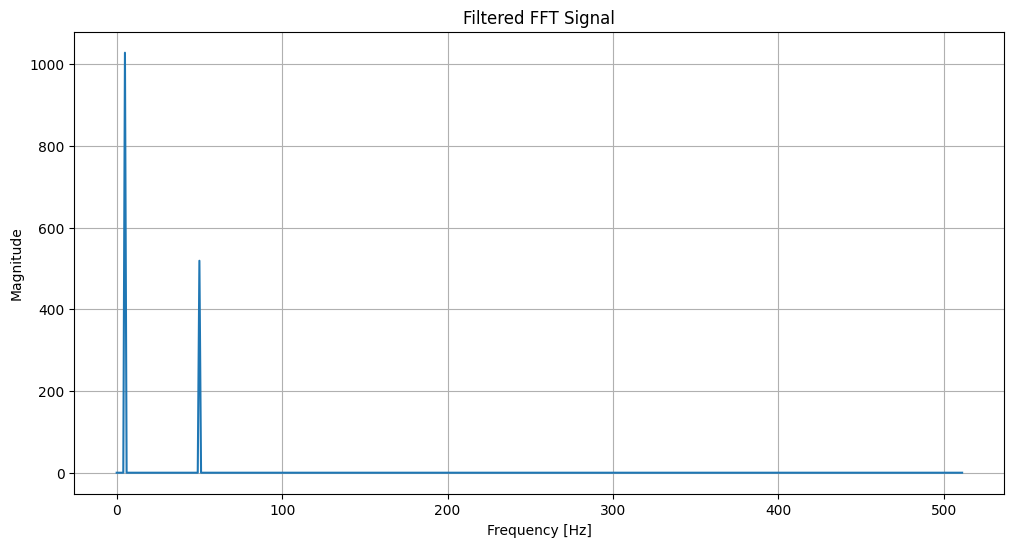

/var/folders/1r/nr0_b6h93gnbrdl1p0899fsh0000gn/T/ipykernel_4572/2243463867.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[n] += X[k] * np.exp(2j * np.pi * k * n / N)


In [176]:
denoised_signal, noise = algorithm(noisy_signal, 150)

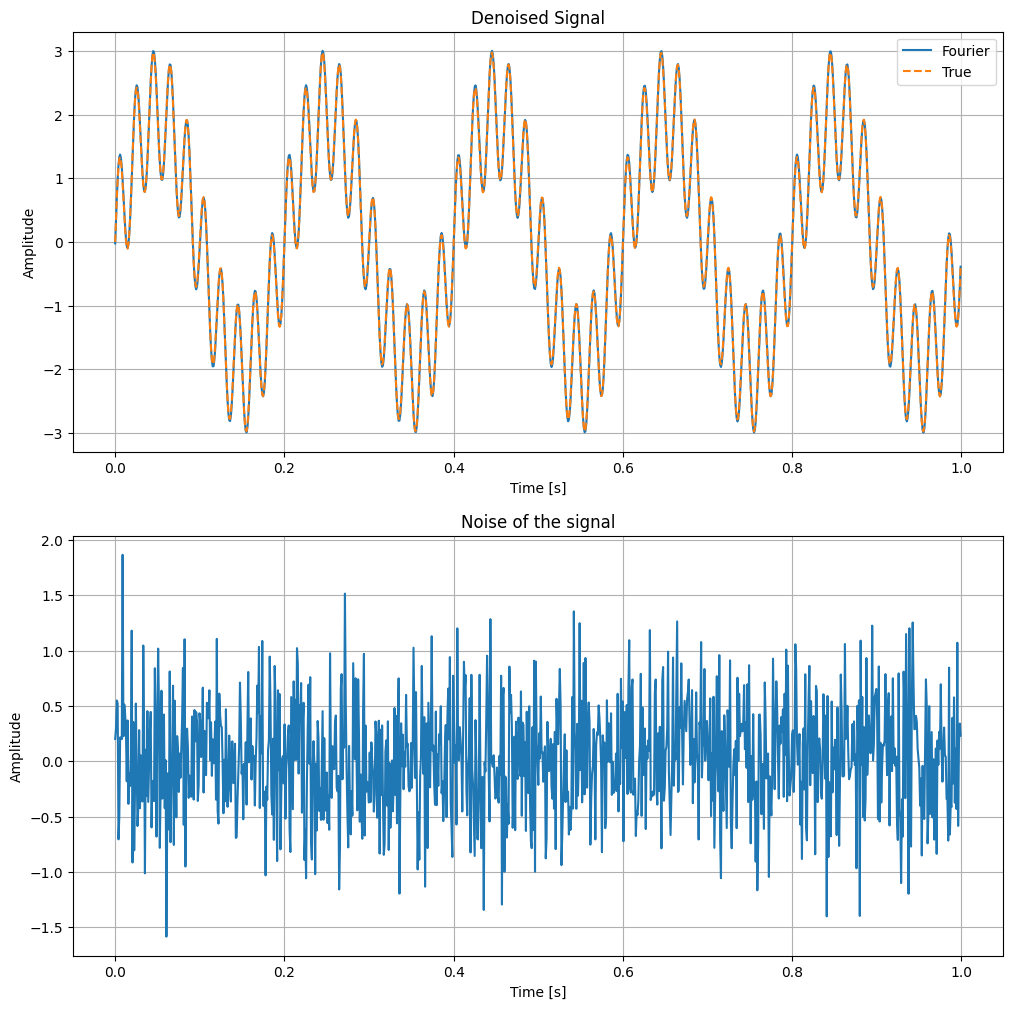

In [177]:

plt.figure(figsize=(12, 12))
plt.subplot(2,1,1)

# Plot the denoised signal
plt.plot(t, denoised_signal, label='Fourier')
plt.plot(t, signal, '--', alpha=1, label='True')
plt.title('Denoised Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.subplot(2,1,2)

# Plot the noise
plt.plot(t, noise)
plt.title('Noise of the signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# Задание 2

Предисловие: Часть задания ARIMA проводилось на домашке майнора ПЗАД (2021-2022) - понравился выбранный тогда ряд и часть отображений

In [73]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [74]:
# считаем файлы
ts1=pd.read_csv('station_manaus.csv')
ts1 = ts1[['YEAR', 'JAN', 'FEB', 'MAR',	'APR', 'MAY',	'JUN', 'JUL',	'AUG',	'SEP',	'OCT',	'NOV',	'DEC']]
ts1

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1910,27.29,26.99,26.49,26.19,27.19,27.49,27.69,27.99,28.99,28.29,28.29,27.79
1,1911,26.99,27.39,27.39,27.29,27.19,26.99,27.39,28.29,28.99,29.09,28.79,28.29
2,1912,28.99,28.79,28.29,27.99,27.29,28.09,27.39,28.79,28.29,29.29,29.19,27.49
3,1913,27.19,28.09,27.29,27.59,26.99,27.59,27.69,27.69,28.69,28.69,28.79,28.49
4,1914,28.79,27.69,27.69,27.59,27.59,27.49,28.59,28.39,29.59,29.09,28.89,28.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2015,28.10,28.59,28.25,28.45,28.50,29.00,29.30,30.80,32.30,31.65,30.60,30.15
106,2016,30.10,999.90,28.45,28.80,29.15,28.85,29.25,30.05,29.55,30.45,29.90,28.10
107,2017,27.85,27.75,27.95,28.20,29.30,29.10,28.80,30.85,29.80,29.30,29.50,28.20
108,2018,28.05,28.35,28.65,28.05,28.20,28.50,29.15,29.65,30.40,31.20,29.90,27.50


In [75]:
def year_to_monthly(pd_0, year, months):
    data_for_year = pd.DataFrame(columns=['date', 'temp'])
    for i, month in enumerate(months):
        data_for_year.loc[i] = [str(int(pd_0[year])) + '-' + '{:02d}'.format(i+1), pd_0.loc[month]]
    return data_for_year

del_rows = ts1[(ts1[['JAN', 'FEB', 'MAR',	'APR', 'MAY',	'JUN', 'JUL',	'AUG',	'SEP',	'OCT',	'NOV',	'DEC']] > 100).any(axis=1)].index
ts1 = ts1.drop(del_rows)
ts1 = ts1[:20]
ts1_monthly = pd.DataFrame(columns=['date', 'temp'])
for year in ts1.index:
    ts1_0 = year_to_monthly(ts1.loc[year], 'YEAR', ['JAN', 'FEB', 'MAR',	'APR', 'MAY',	'JUN', 'JUL',	'AUG',	'SEP',	'OCT',	'NOV',	'DEC'])
    ts1_monthly = pd.concat([ts1_monthly, ts1_0], ignore_index=True)

/var/folders/1r/nr0_b6h93gnbrdl1p0899fsh0000gn/T/ipykernel_9279/657527217.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ts1_monthly = pd.concat([ts1_monthly, ts1_0], ignore_index=True)


<Axes: xlabel='date'>

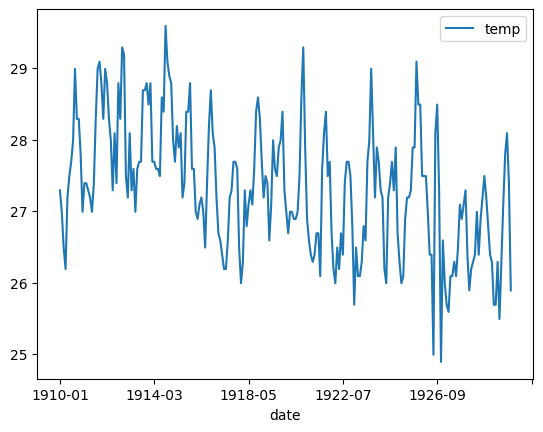

In [76]:
ts1_monthly.plot(x='date', y='temp')

In [77]:
time2 = 'date'
value2 = 'temp'
train_rate = 0.8

In [82]:
N2 = len(ts1_monthly)
train_border = int(N2 * train_rate)
ts_train = ts1_monthly[:train_border]
ts_test = ts1_monthly[train_border:]

In [83]:
ts_train

,date,temp
0,1910-01,27.29
1,1910-02,26.99
2,1910-03,26.49
3,1910-04,26.19
4,1910-05,27.19
...,...,...
187,1925-08,27.89
188,1925-09,27.89
189,1925-10,29.09
190,1925-11,28.49


In [84]:
ts_train = ts_train[[time2, value2]]
ts_train[time2] = pd.to_datetime(ts_train[time2])
ts_train.set_index(time2, inplace=True)
ts_train

,temp
date,
1910-01-01,27.29
1910-02-01,26.99
1910-03-01,26.49
1910-04-01,26.19
1910-05-01,27.19
...,...
1925-08-01,27.89
1925-09-01,27.89
1925-10-01,29.09


In [86]:
ts_test = ts_test[[time2, value2]]
ts_test[time2] = pd.to_datetime(ts_test[time2])
ts_test.set_index(time2, inplace=True)

In [87]:
ts_test

,temp
date,
1926-01-01,27.49
1926-02-01,27.49
1926-03-01,27.49
1926-04-01,26.99
1926-05-01,26.39
1926-06-01,26.39
1926-07-01,24.99
1926-08-01,28.09
1926-09-01,28.49


<Axes: ylabel='Frequency'>

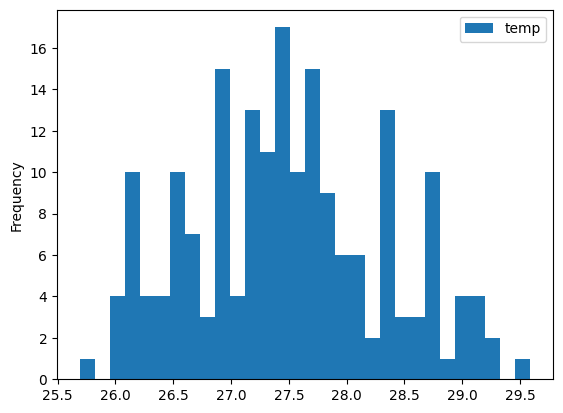

In [88]:
ts_train.plot(kind = "hist", bins = 30)

Данные имеют более-менее нормальное распределение, логарифмирование не требуется

In [89]:
train_border

192

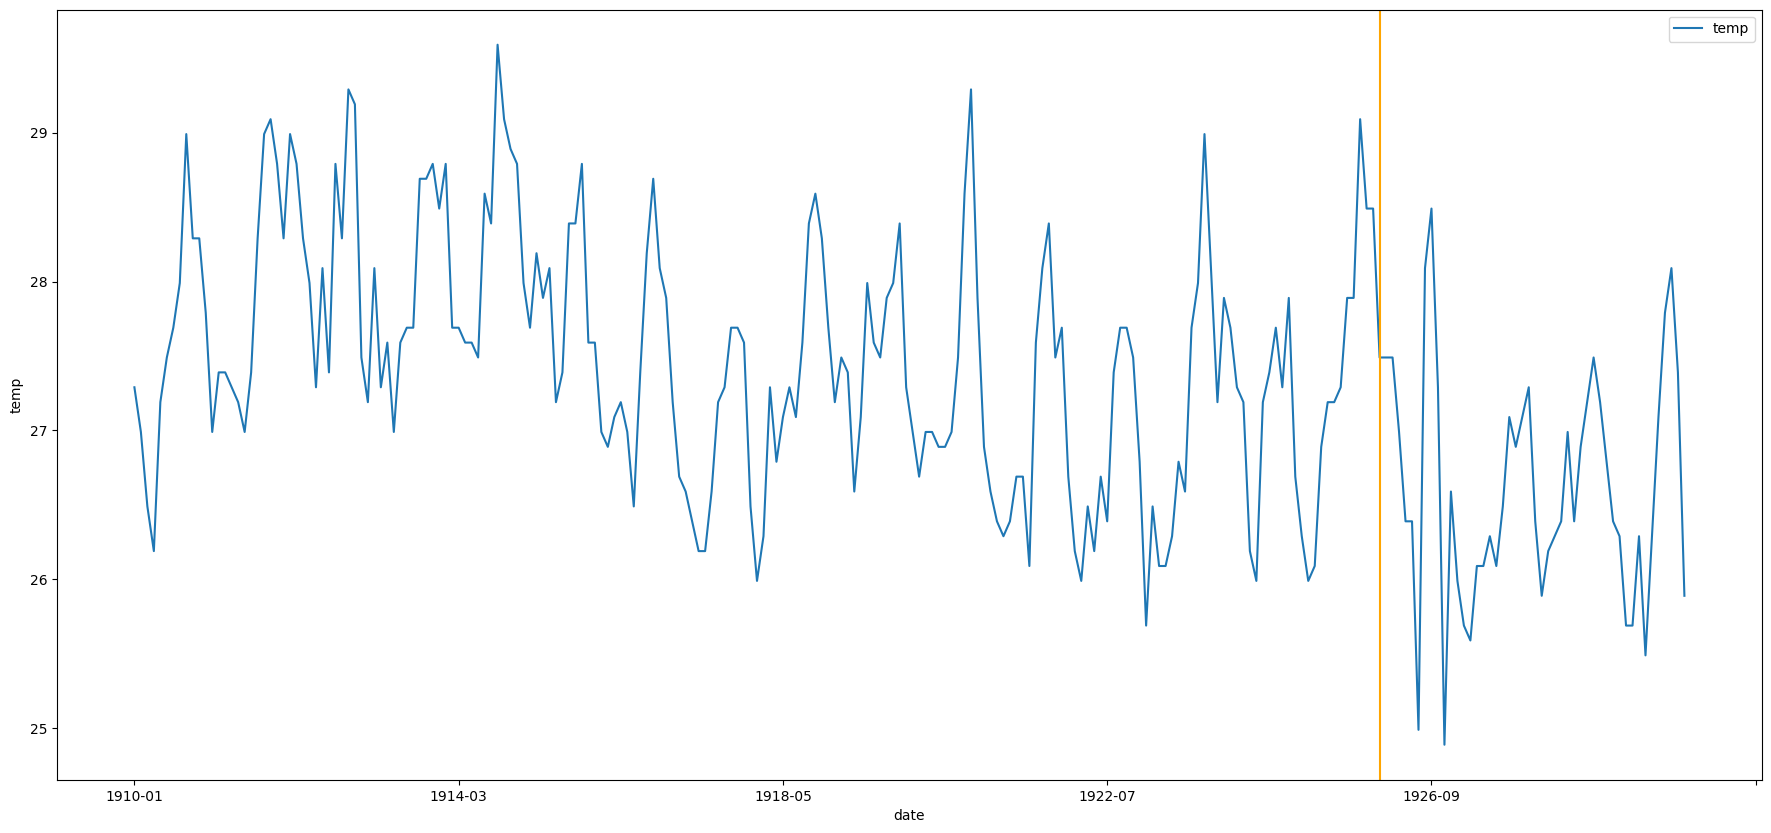

In [90]:
fig, ax = plt.subplots(1, figsize=(22, 10))
ts1_monthly.plot(x=time2, y=value2, ax=ax, ylabel=value2)
ax.axvline(train_border, color='orange')

plt.show()

## Сезонность

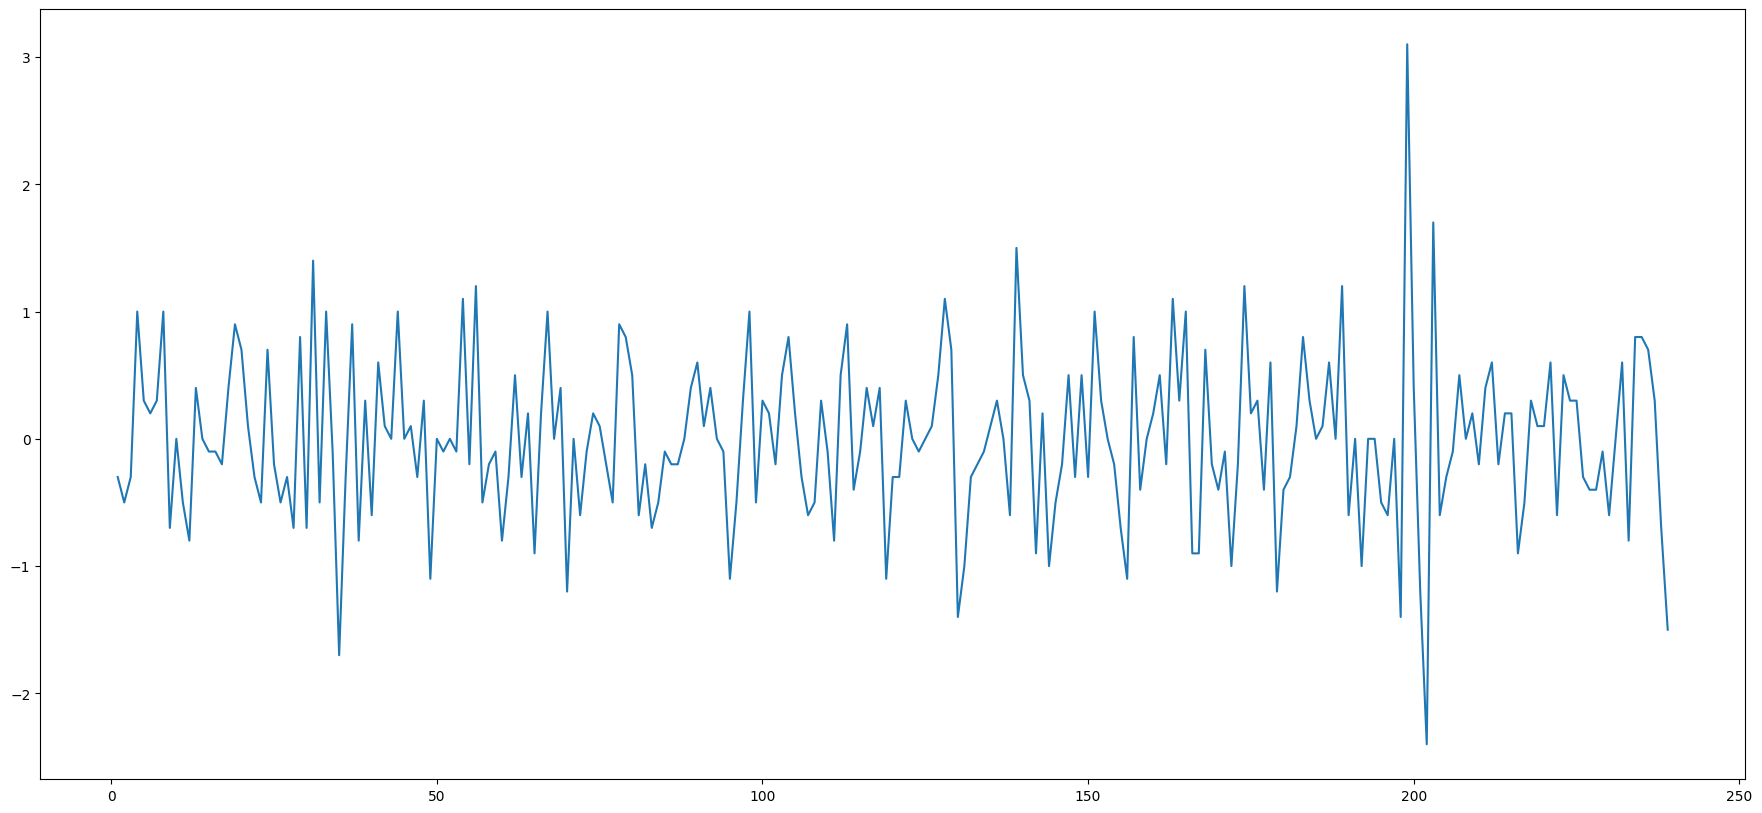

In [91]:
plt.figure(figsize=(22, 10))
plt.plot(ts1_monthly[value2] - ts1_monthly[value2].shift())

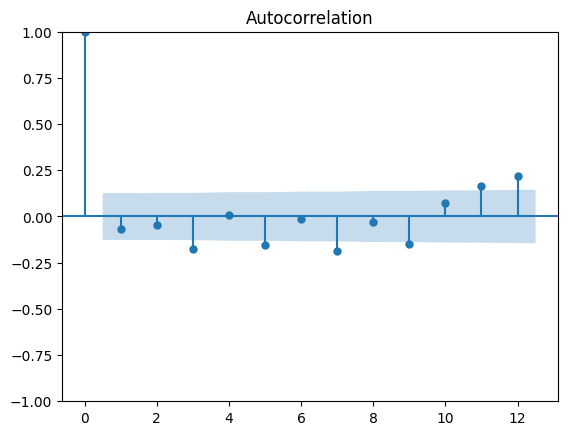

In [92]:
# посчитайте и нарисуйте график автокорреляционной функции
# hint, используйте для этого np.correlate(..., mode='full')
import statsmodels.api as sm

sm.graphics.tsa.plot_acf((ts1_monthly[value2] - ts1_monthly[value2].shift()).dropna(), lags=12, ax=None)
plt.show()

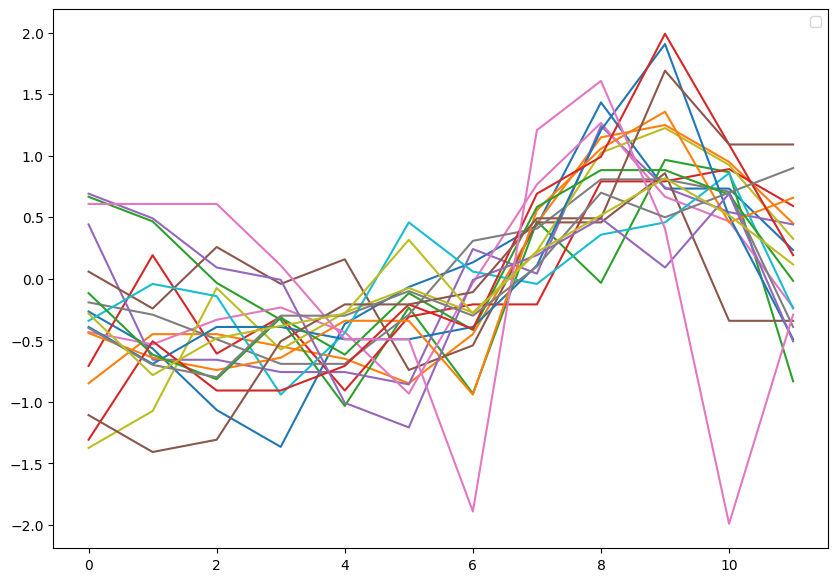

In [191]:
s = 12
# разбить временной ряд на повторяющиеся участки по длине сезонной составляющей и нарисовать их наложенными
fig, ax = plt.subplots(figsize=(10,7))
for week, i in enumerate(range(0, N2-s, s)):
    plt.plot(np.arange(0,s),ts1_monthly[i:i+s][value2]-ts1_monthly[i:i+s][value2].mean())
plt.legend([])

## ARIMA

In [186]:
from statsmodels.tsa.stattools import adfuller

def get_stationar_series(series):
    i = 0
    while True:
        hypo = adfuller(series)
        if hypo[1] > 0.05:
            print(f"{i}-й ряд нестационарен, дифференцирую")
            series = series.diff().dropna()
        else:
            print(f"{i}-й ряд стационарен")
            return i, series
        i += 1

# ADF тест до стационарности ряда
i_d, st_train = get_stationar_series(ts_train[value2])


0-й ряд нестационарен, дифференцирую
1-й ряд стационарен


Исходя из числа дифференцирования, I = 1

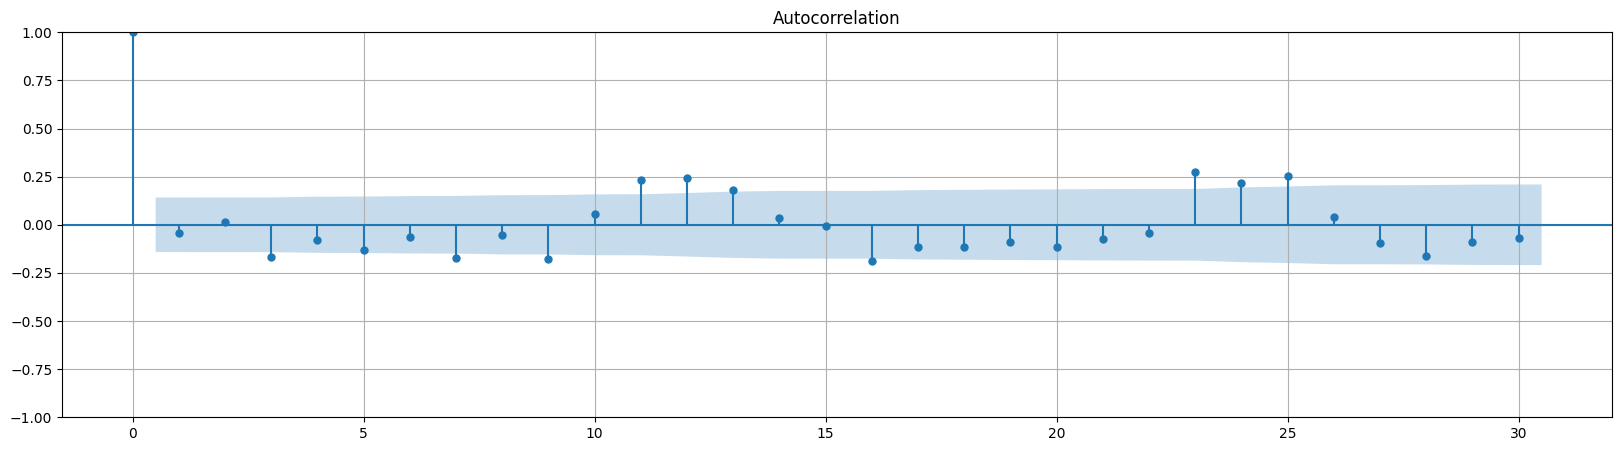

In [118]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(20,5))
plt.grid()
plot_acf(st_train, ax=plt.gca(), lags = 30)
plt.show()

Резкое снижение ACF с самого начала => q = 1

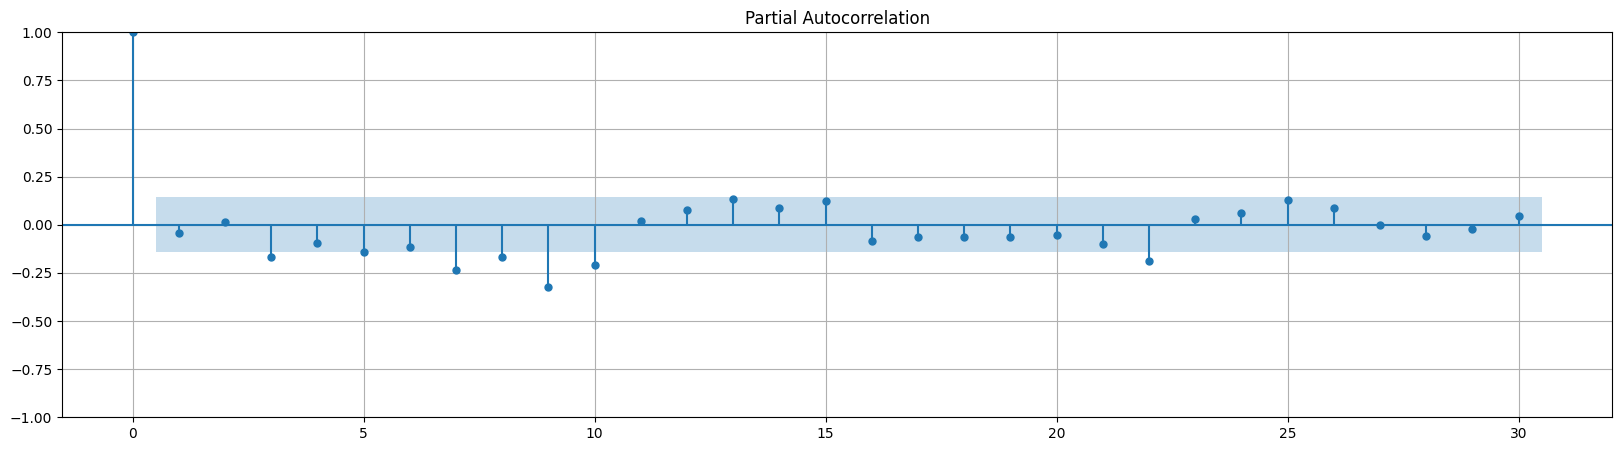

In [159]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(20,5))
plt.grid()
plot_pacf(st_train, ax=plt.gca(), lags = 30)
plt.show()

Резкое снижение PACF с самого начала => p = 1

In [187]:
from statsmodels.tsa.arima.model import ARIMA

# ваш код обучения моделей здесь
sarima = ARIMA(ts_train,order=(1,1,1),seasonal_order=(1,1,1,12))
model_fit = sarima.fit()
print(model_fit.params)

/Users/ilyapchelintsev/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ilyapchelintsev/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ilyapchelintsev/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ar.L1       0.161732
ma.L1      -0.699183
ar.S.L12   -0.081434
ma.S.L12   -0.998253
sigma2      0.195537
dtype: float64


In [188]:
ts_pred = model_fit.predict(ts_test.index.min(), ts_test.index.max())

In [189]:
ts_pred

1926-01-01    27.685203
1926-02-01    27.577199
1926-03-01    27.484071
1926-04-01    27.353029
1926-05-01    27.307954
1926-06-01    27.463297
1926-07-01    27.624180
1926-08-01    28.225729
1926-09-01    28.766436
1926-10-01    28.857259
1926-11-01    28.547796
1926-12-01    27.855817
1927-01-01    27.514992
1927-02-01    27.461061
1927-03-01    27.394934
1927-04-01    27.341534
1927-05-01    27.324855
1927-06-01    27.467595
1927-07-01    27.623528
1927-08-01    28.224952
1927-09-01    28.721628
1927-10-01    28.902775
1927-11-01    28.569652
1927-12-01    27.934024
1928-01-01    27.555416
1928-02-01    27.497082
1928-03-01    27.428756
1928-04-01    27.369033
1928-05-01    27.350042
1928-06-01    27.493808
1928-07-01    27.650144
1928-08-01    28.251578
1928-09-01    28.751840
1928-10-01    28.925632
1928-11-01    28.594435
1928-12-01    27.954219
1929-01-01    27.578688
1929-02-01    27.520712
1929-03-01    27.452565
1929-04-01    27.393357
1929-05-01    27.374554
1929-06-01    27

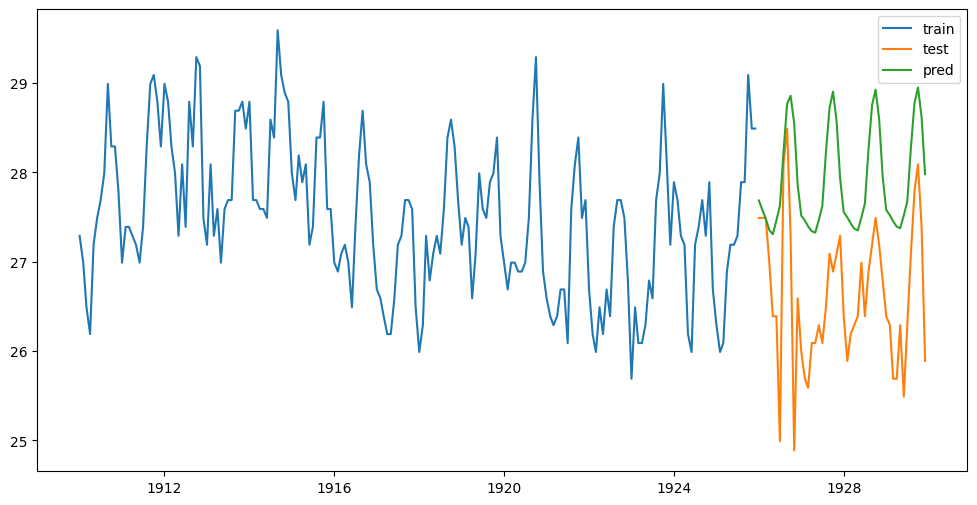

In [197]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(ts_train, label='train')
ax.plot(ts_test, label='test')
ax.plot(ts_pred, label='pred')
ax.legend()